In [2]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf


from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [10]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")

In [12]:
folds.head()

fold  mag    grp                                           filename
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [14]:
df = pd.DataFrame(folds.iloc[:7909])
df.head()

fold  mag    grp                                           filename
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [16]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

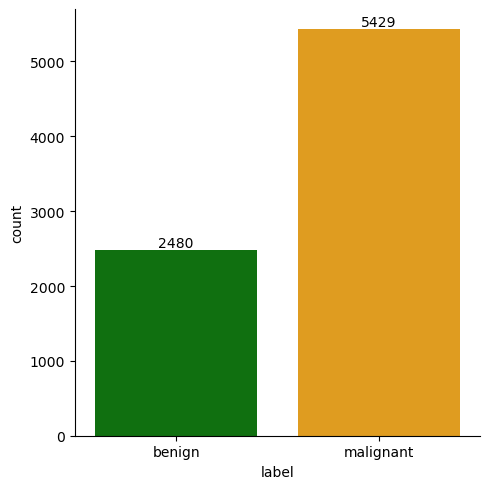

In [18]:
# Striping any leading/trailing whitespace from the below labels
df['label'] = df['label'].str.strip()

# Creating the plot with counts
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)

# This code is to ensure that the bar data labels is served to all the bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# visualization of the plot
plt.show()

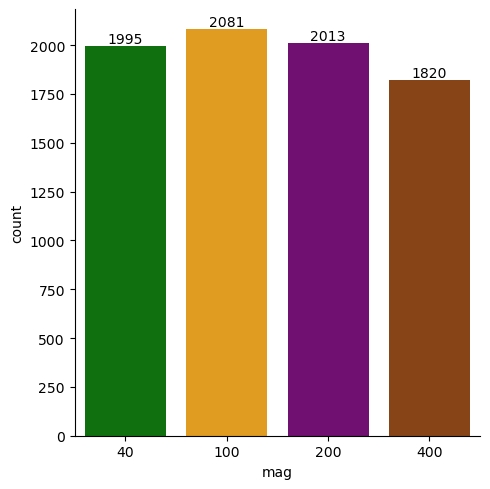

In [20]:
g = sns.catplot(x="mag", data=df, kind="count", hue="mag", palette=['green', 'orange', 'purple', "#9a4204"], legend=False)

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

# Show the plot
plt.show()

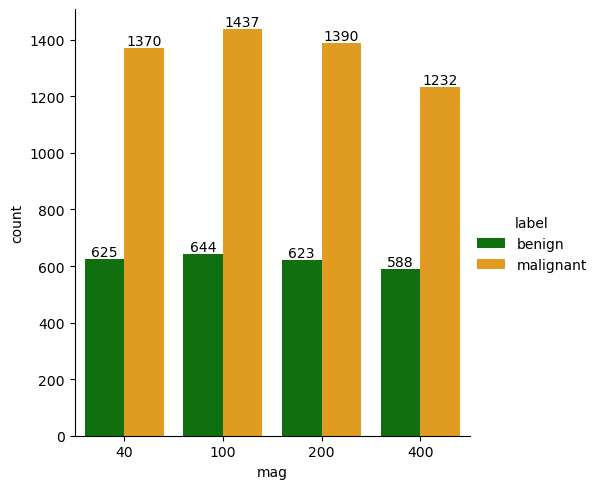

In [22]:
g = sns.catplot(x="mag", data=df, hue="label", kind="count", palette=['green', 'orange'])
for ax in g.axes.flat:
    for c in ax.containers:
        ax.bar_label(c)
plt.show()

In [24]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [26]:
df

fold  mag    grp                                           filename  \
0        1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1        1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2        1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3        1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4        1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
...    ...  ...    ...                                                ...   
7904     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
7905     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
7906     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
7907     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   
7908     1  400   test  BreaKHis_v1/histology_slides/breast/malignant/...   

          label  label_int  
0        benign          0  
1        benign          0  
2        benign          0  
3        benign          0  
4        benign          0  
...         ...        ...  
7904  malignant          1  
7905  malignant          1  
7906  malignant          1  
7907  malignant          1  
7908  malignant          1  

[7909 rows x 6 columns]

In [28]:
random_state = 42

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [32]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(( "/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/"+ X_test, y_test))

In [34]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

In [36]:
X_trainset = train_loader.shuffle(len(X_train)).map(parse_image).map(resize_rescale).batch(64)
X_testset = test_loader.shuffle(len(X_test)).map(parse_image).map(resize_rescale).batch(64)

2024-07-13 17:33:47.746561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


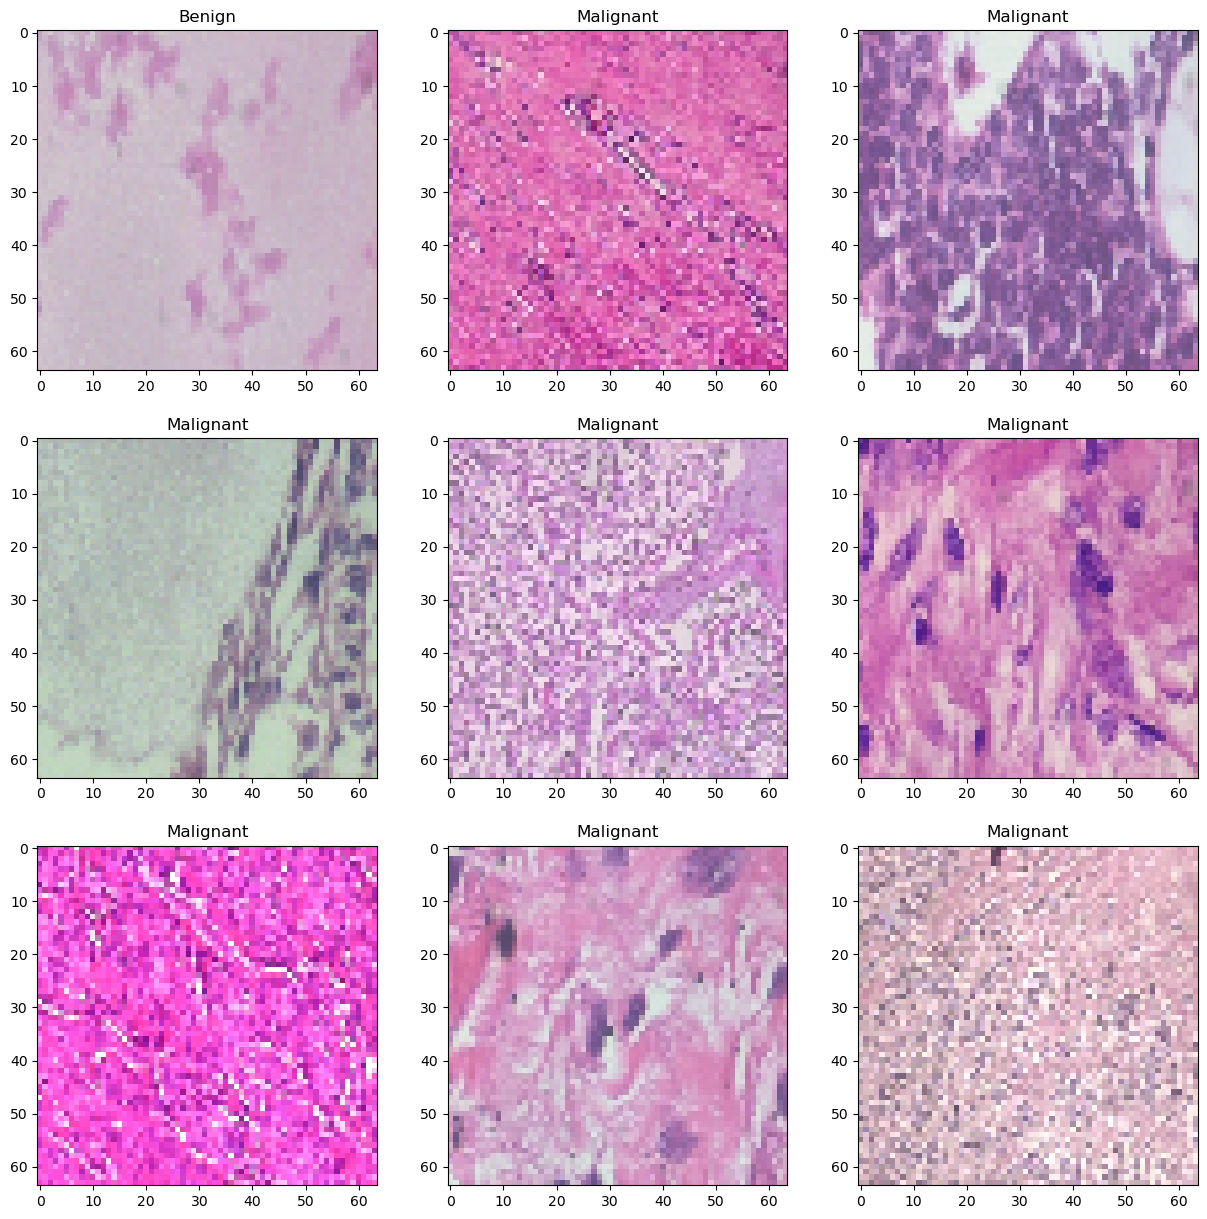

In [38]:
# Visualize sample images
fig = plt.figure(figsize=(15, 15))
for i, img in enumerate(X_trainset.take(9)):
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(img[1][i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[0][i])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


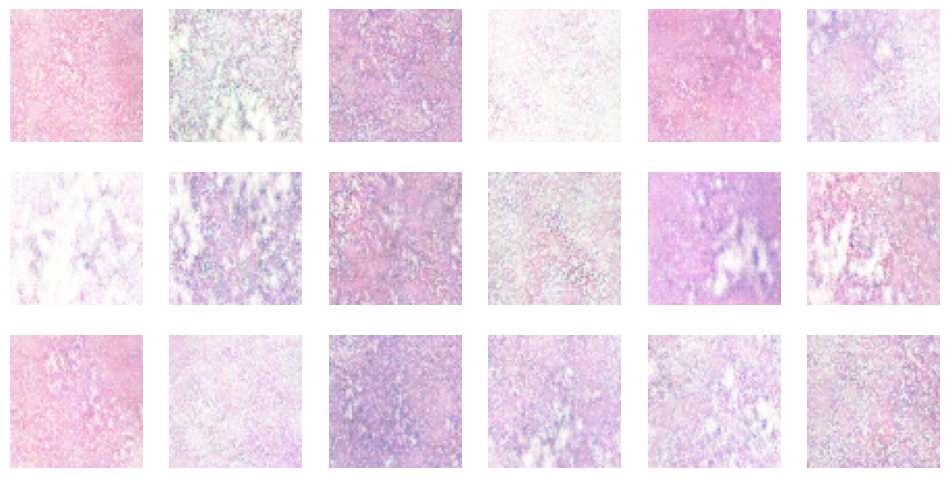

Time taken for epoch 500 is 129.00831198692322 sec

Saving checkpoint for epoch 500 at checkpoints/tensorflow/DCGAN/ckpt-35


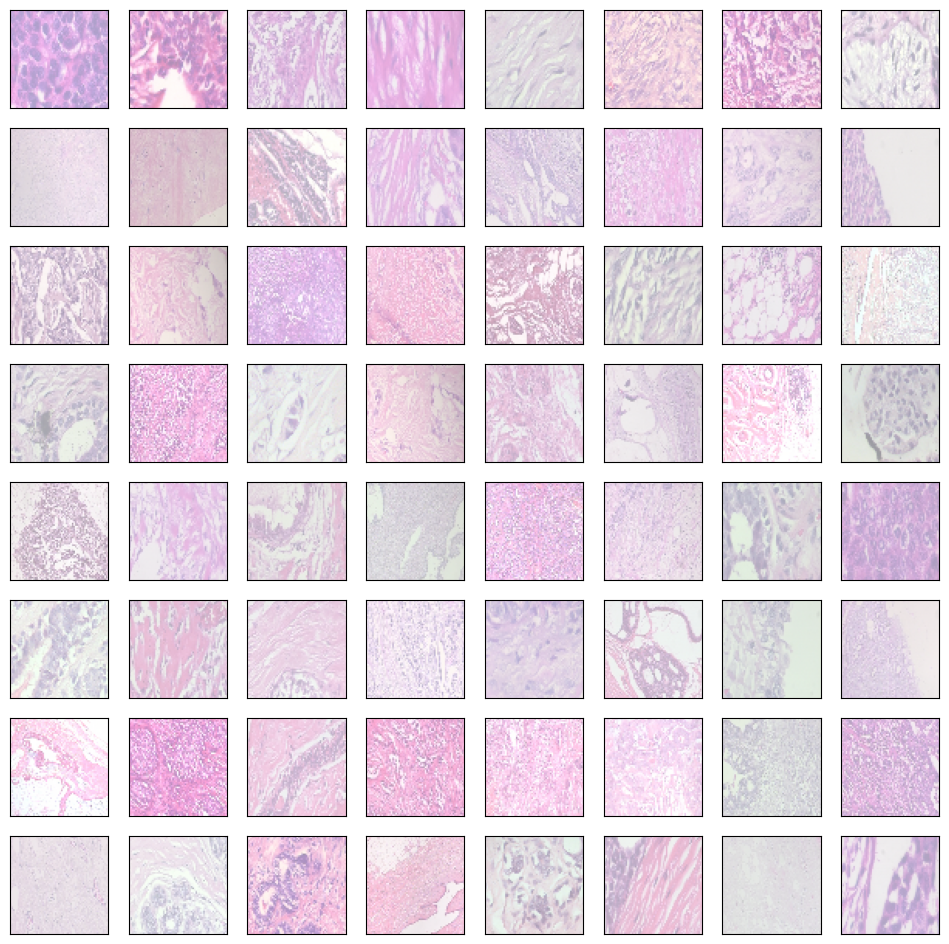

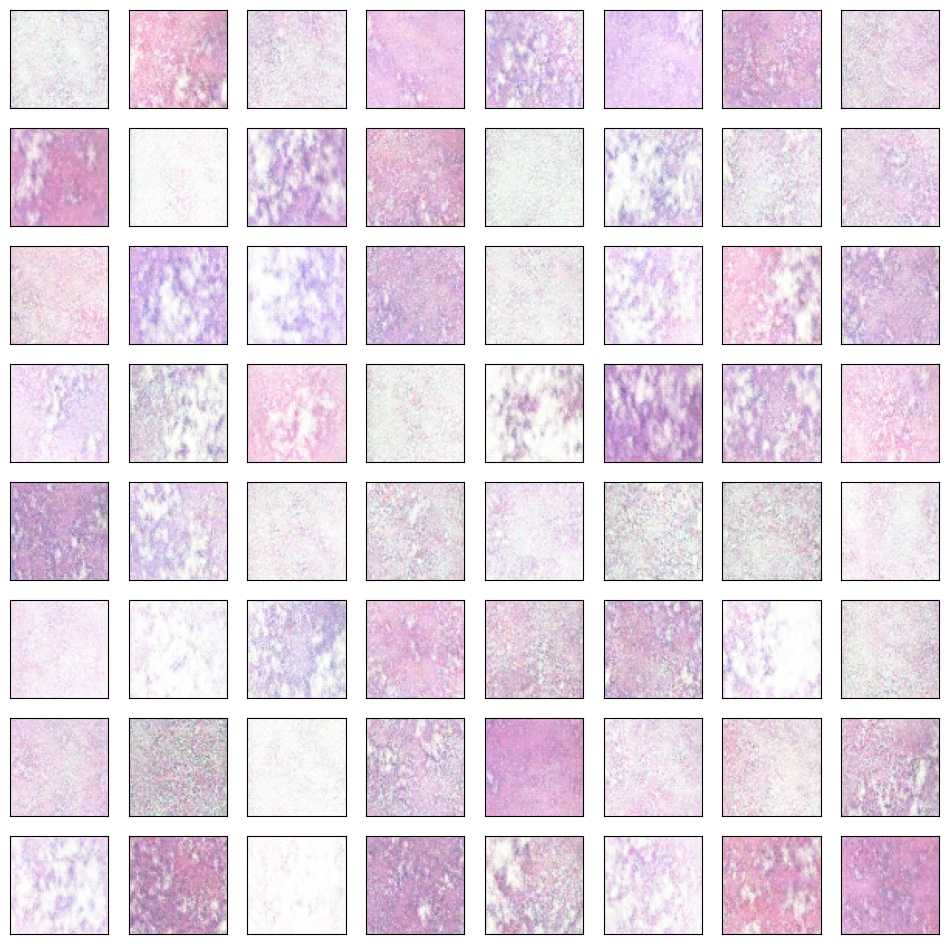

In [44]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
MODEL_NAME = 'DCGAN'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data')
TARGET_IMG_SIZE = 64
BATCH_SIZE = 128
NOISE_DIM = 100
LAMBDA = 10
EPOCHS = 500
CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCH = 15
N_CRITIC = 3
LR = 1e-4
MIN_LR = 0.000001
DECAY_FACTOR = 1.00004

# Ensure output path exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# File writer for logging
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

# Data preprocessing functions
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [TARGET_IMG_SIZE, TARGET_IMG_SIZE]) / 255.0
    return img, label

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (TARGET_IMG_SIZE, TARGET_IMG_SIZE), method='bicubic', antialias=True)
    images = normalize(images)
    return images

# Load the CSV file
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])
df["label"] = df["filename"].apply(lambda x: x.split("/")[3]).str.strip()
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

# Drop the 'filename' and 'grp' columns for SMOTE
X = df.drop(columns=['label', 'filename', 'grp'])
y = df['label_int']

# Ensure all columns in X are numerical for SMOTE
X = X.apply(pd.to_numeric, errors='coerce')

# Impute missing values using the mean of each column
X = X.fillna(X.mean())

# Check if there are still any NaN values in the data
if X.isnull().values.any():
    print("Data still contains NaN values. Please check the data.")
else:
    # Apply SMOTE to handle imbalance
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the model
    model = RandomForestClassifier(random_state=42)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Evaluate the model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_mat)

    # Classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # Function to plot the scores
    def plotScoresHist(conf_mat):
        scores = pd.DataFrame(conf_mat)
        classes = [0, 1]
        p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
        plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
        plt.title("Percentage of correctly classified images")
        plt.xlabel('Class')
        plt.ylabel('Percentage')
        plt.xticks(["Benign", "Malignant"])
        plt.show()

    # Plot the confusion matrix scores
    plotScoresHist(conf_mat)

    # Split the data for GAN
    random_state = 42
    X_train_gan, X_test_gan, y_train_gan, y_test_gan = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=random_state)
    train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train_gan.astype(str), y_train_gan))
    test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test_gan.astype(str), y_test_gan))

    # Create datasets
    X_trainset = train_loader.shuffle(len(X_train_gan)).map(parse_image).map(resize_rescale).batch(64)
    X_testset = test_loader.shuffle(len(X_test_gan)).map(parse_image).map(resize_rescale).batch(64)

    # Visualize sample images
    fig = plt.figure(figsize=(15, 15))
    for i, (img, label) in enumerate(X_trainset.take(1)):
        for j in range(img.shape[0]):
            ax = fig.add_subplot(8, 8, j + 1)
            if label[j] == 0:
                ax.title.set_text("Benign")
            else:
                ax.title.set_text("Malignant")
            plt.imshow(img[j])
    plt.show()

    # Creating the generator model
    def CGAN_generator(input_z_shape=(NOISE_DIM,)):
        input_z_layer = Input(shape=input_z_shape)
        z = Dense(4*4*512, use_bias=False)(input_z_layer)
        z = Reshape((4, 4, 512))(z)
        x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        output = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        model = Model(inputs=input_z_layer, outputs=output)
        return model

    # Creating the discriminator model
    def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)):
        input_x_layer = Input(shape=input_x_shape)
        x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
        x = LeakyReLU()(x)
        x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = LeakyReLU()(x)
        x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = LeakyReLU()(x)
        x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Flatten()(x)
        output = Dense(1)(x)
        model = Model(inputs=input_x_layer, outputs=output)
        return model

    # Initialize models
    generator = CGAN_generator()
    discriminator = CGAN_discriminator()

    # Optimizers
    D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
    G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

    # Learning rate decay
    def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
        new_lr = max(current_lr / decay_factor, MIN_LR)
        return new_lr

    def set_learning_rate(new_lr):
        D_optimizer.learning_rate.assign(new_lr)
        G_optimizer.learning_rate.assign(new_lr)

    # Checkpoints
    checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)
    ckpt = tf.train.Checkpoint(generator=generator, discriminator=discriminator, G_optimizer=G_optimizer, D_optimizer=D_optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    # Restore latest checkpoint if exists
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
        CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
        print(f'Latest checkpoint of epoch {CURRENT_EPOCH} restored!!')

    # Generate and save images
    def generate_and_save_images(model, epoch, test_input, figure_size=(12, 6), subplot=(3, 6), save=True, is_flatten=False):
        predictions = model.predict(test_input)
        if is_flatten:
            predictions = predictions.reshape(-1, TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3).astype('float32')
        fig = plt.figure(figsize=figure_size)
        for i in range(predictions.shape[0]):
            axs = plt.subplot(subplot[0], subplot[1], i + 1)
            plt.imshow(predictions[i] * 0.5 + 0.5)
            plt.axis('off')
        if save:
            plt.savefig(os.path.join(OUTPUT_PATH, f'image_at_epoch_{epoch:04d}.png'))
        plt.show()

    # Generate initial images
    num_examples_to_generate = 18
    sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
    generate_and_save_images(generator, 0, [sample_noise], figure_size=(12, 6), subplot=(3, 6), save=False, is_flatten=False)

    # Training steps
    @tf.function
    def WGAN_GP_train_d_step(real_image, batch_size, step):
        noise = tf.random.normal([batch_size, NOISE_DIM])
        epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
        with tf.GradientTape(persistent=True) as d_tape:
            with tf.GradientTape() as gp_tape:
                fake_image = generator([noise], training=True) 
                fake_image_mixed = epsilon * tf.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
                fake_mixed_pred = discriminator([fake_image_mixed], training=True)
            grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
            grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
            gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
            fake_pred = discriminator([fake_image], training=True)
            real_pred = discriminator([real_image], training=True)
            D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
        D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
        D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
        if step % 10 == 0:
            with file_writer.as_default():
                tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

    @tf.function
    def WGAN_GP_train_g_step(real_image, batch_size, step):
        noise = tf.random.normal([batch_size, NOISE_DIM])
        with tf.GradientTape() as g_tape:
            fake_image = generator([noise], training=True)
            fake_pred = discriminator([fake_image], training=True)
            G_loss = -tf.reduce_mean(fake_pred)
        G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
        G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
        if step % 10 == 0:
            with file_writer.as_default():
                tf.summary.scalar('G_loss', G_loss, step=step)

    # Training loop
    current_learning_rate = LR
    trace = True
    n_critic_count = 0

    for epoch in range(CURRENT_EPOCH, EPOCHS + 1):
        start = time.time()
        print(f'Start of epoch {epoch}')
        current_learning_rate = learning_rate_decay(current_learning_rate)
        set_learning_rate(current_learning_rate)
        for step, (image, label) in enumerate(X_trainset):
            current_batch_size = image.shape[0]
            WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count += 1
            if n_critic_count >= N_CRITIC:
                WGAN_GP_train_g_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
                n_critic_count = 0
            if step % 10 == 0:
                print('.', end='')
        clear_output(wait=True)
        generate_and_save_images(generator, epoch, [sample_noise], figure_size=(12, 6), subplot=(3, 6), save=True, is_flatten=False)
        if epoch % SAVE_EVERY_N_EPOCH == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch} at {ckpt_save_path}')
        print(f'Time taken for epoch {epoch} is {time.time()-start} sec\n')

    # Save final checkpoint
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {EPOCHS} at {ckpt_save_path}')

    # Generate fake images for visualization
    test_noise = tf.random.normal([64, NOISE_DIM])
    prediction = generator(test_noise, training=False)

    # Plot images
    def image_grid(images, fig):
        for i in range(64):
            axs = fig.add_subplot(8, 8, i + 1)
            axs.set_xticks([])
            axs.set_yticks([])
            axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))

    # Plot real images
    fig1 = plt.figure(figsize=(12, 12))
    real_images = next(iter(X_trainset))[0][:64]
    image_grid(real_images.numpy(), fig1)
    plt.show()

    # Plot fake images from the last epoch
    fig2 = plt.figure(figsize=(12, 12))
    image_grid(prediction.numpy(), fig2)
    plt.show()


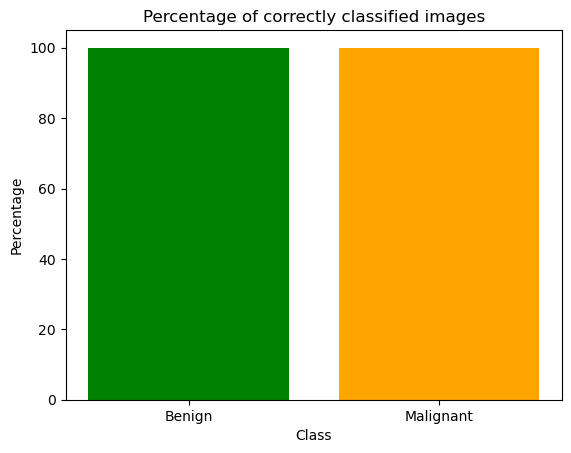

In [45]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)